# Forecasting Sticker Sales

### Dataset Description
For this challenge, you will be predicting multiple years worth of sales for various Kaggle-branded stickers from different fictitious stores in different (real!) countries. This dataset is completely synthetic, but contains many effects you see in real-world data, e.g., weekend and holiday effect, seasonality, etc.

Good luck!

### Files
- train.csv - the training set, which includes the sales data for each date-country-store-item combination.
- test.csv - the test set; your task is to predict the corresponding item sales (num_sold) for each date-country-store-item combination. Note the Public leaderboard is scored on the first year of the data, and the Private on the remaining.
- sample_submission.csv - a sample submission file in the correct format

In [105]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot


In [106]:
# Function to highlight values above and below a threshold


def highlight_values(val, threshold=0.5):
    if val > threshold:
        return 'background-color: yellow'  # Highlight values above 0.5

In [107]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

sub_file = pd.read_csv('data/sample_submission.csv')


In [108]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


# Missing Values

In [109]:
# check for missing values

train.isnull().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [110]:
# fill missing values with 0

train['num_sold'].fillna(0, inplace=True)

/var/folders/d4/rcb0hfcs0bzgr7z0mw72lc_w0000gn/T/ipykernel_5630/3231347797.py:3: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [111]:
# value counts in pie graphs for store, country, product

train['country'].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [112]:
train['store'].value_counts()

store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64

In [113]:
train['product'].value_counts()

product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64

In [114]:
print(train['date'].max())
print(train['date'].min())

2016-12-31
2010-01-01


In [115]:
grouped_df = train.groupby(['country', 'store', 'product'])['num_sold'].count().reset_index()
grouped_df.columns = ['Country', 'Store', 'Product', 'Num Sold']

# Display as a pretty table
print(tabulate(grouped_df, headers='keys', tablefmt='grid'))

+----+-----------+----------------------+--------------------+------------+
|    | Country   | Store                | Product            |   Num Sold |
+====+===========+======================+====================+============+
|  0 | Canada    | Discount Stickers    | Holographic Goose  |       2557 |
+----+-----------+----------------------+--------------------+------------+
|  1 | Canada    | Discount Stickers    | Kaggle             |       2557 |
+----+-----------+----------------------+--------------------+------------+
|  2 | Canada    | Discount Stickers    | Kaggle Tiers       |       2557 |
+----+-----------+----------------------+--------------------+------------+
|  3 | Canada    | Discount Stickers    | Kerneler           |       2557 |
+----+-----------+----------------------+--------------------+------------+
|  4 | Canada    | Discount Stickers    | Kerneler Dark Mode |       2557 |
+----+-----------+----------------------+--------------------+------------+
|  5 | Canad

### From inspection it looks like Holographic Goose has a large amount of variance in the count of sales in Canada and Kenya for all of their stores.

In [116]:
summary_table = train.groupby(['country', 'product'])['num_sold'].rolling(7).mean().reset_index()
summary_table = train.groupby(['country', 'product'])['num_sold'].mean().unstack()
summary_table

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
country,,,,,
Canada,107.746057,1292.282753,1069.633034,583.778647,681.808500
Finland,177.405944,1270.898709,1048.214574,572.768609,671.928692
Italy,128.415852,920.549602,760.745535,415.487681,486.008343
Kenya,2.335289,31.393169,25.870291,13.884761,16.353670
Norway,337.579194,2414.199713,1994.730153,1089.705254,1276.587798
Singapore,204.719724,1464.983575,1210.871073,661.207274,773.480250


In [117]:
# calculate the % share for the summary_table by country
sums = summary_table.sum(axis=1)
summary_table = summary_table.div(sums, axis=0)
summary_table

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
country,,,,,
Canada,0.028846,0.345970,0.286362,0.156289,0.182534
Finland,0.047419,0.339702,0.280180,0.153097,0.179602
Italy,0.047365,0.339535,0.280593,0.153248,0.179259
Kenya,0.025995,0.349445,0.287969,0.154555,0.182037
Norway,0.047461,0.339416,0.280442,0.153203,0.179477
Singapore,0.047441,0.339489,0.280602,0.153225,0.179243


In [118]:
summary_table = summary_table - summary_table.mean(axis=0)
summary_table.style.background_gradient(axis=0,cmap="GnBu")

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
country,,,,,
Canada,-0.011909,0.003710,0.003671,0.002353,0.002175
Finland,0.006665,-0.002557,-0.002511,-0.000839,-0.000757
Italy,0.006610,-0.002724,-0.002098,-0.000688,-0.001100
Kenya,-0.014760,0.007186,0.005277,0.000618,0.001678
Norway,0.006706,-0.002843,-0.002249,-0.000733,-0.000881
Singapore,0.006686,-0.002771,-0.002089,-0.000711,-0.001116


### Generally Product share by Country look relatively consistent with outliers for Holographic Goose and Kaggle Tiers that were previously flagged for Kenya and Canada

In [119]:
summary_table = train.groupby(['store', 'product'])['num_sold'].rolling(7).mean().reset_index()
summary_table = train.groupby(['store', 'product'])['num_sold'].mean().unstack()
sums = summary_table.sum(axis=1)
summary_table = summary_table.div(sums, axis=0)
summary_table

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
store,,,,,
Discount Stickers,0.039167,0.342584,0.283006,0.154460,0.180783
Premium Sticker Mart,0.046497,0.339771,0.280857,0.153306,0.179569
Stickers for Less,0.043808,0.340778,0.281514,0.153877,0.180023


### Premium Sticker Mart generally carries less of the Holographic Goose which could be due to the Canada + Kenya outlier influence

In [120]:
product_share_tot = train.groupby('product')['num_sold'].sum() / train.groupby('product')['num_sold'].sum().sum()
product_share_tot = product_share_tot.reset_index()
product_share_avg = train.groupby('product')['num_sold'].mean() / train.groupby('product')['num_sold'].mean().sum()
product_share_avg = product_share_avg.reset_index()

product_share = pd.concat([product_share_tot, product_share_avg], axis=1)

# drop duplicate columns
product_share.columns = ['product', 'num_sold', 'drop', 'avg_num_sold']
product_share = product_share.drop(columns=['drop'])
product_share['diff'] = product_share['num_sold'] - product_share['avg_num_sold']
product_share

,product,num_sold,avg_num_sold,diff
0,Holographic Goose,0.044145,0.044145,0.000000e+00
1,Kaggle,0.340664,0.340664,-5.551115e-17
2,Kaggle Tiers,0.281497,0.281497,0.000000e+00
3,Kerneler,0.153732,0.153732,0.000000e+00
4,Kerneler Dark Mode,0.179961,0.179961,-2.775558e-17


### notable discrepancy in the Holographic Goose which could be due to the Canada and Kenya anomaly

# Seasonality

In [121]:
# add a column for month, year, and season 
train['month'] = pd.to_datetime(train['date']).dt.month
train['year'] = pd.to_datetime(train['date']).dt.year
train['season'] = train['month'].map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})
train

,id,date,country,store,product,num_sold,month,year,season
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,0.0,1,2010,Winter
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,1,2010,Winter
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,1,2010,Winter
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,1,2010,Winter
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,1,2010,Winter
...,...,...,...,...,...,...,...,...,...
230125,230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,12,2016,Winter
230126,230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,12,2016,Winter
230127,230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,12,2016,Winter
230128,230128,2016-12-31,Singapore,Premium Sticker Mart,Kerneler,1242.0,12,2016,Winter


In [122]:
# plot avg sales by month on a bar graph with plotly

avg_sales_by_month = train.groupby('month')['num_sold'].mean()
px.bar(avg_sales_by_month, x=avg_sales_by_month.index, y=avg_sales_by_month.values, title='Average Sales by Month')

In [123]:
# plot avg sales by month on a bar graph with plotly

avg_sales_by_month = train.groupby('year')['num_sold'].mean()
px.bar(avg_sales_by_month, x=avg_sales_by_month.index, y=avg_sales_by_month.values, title='Average Sales by Year')

In [124]:
# plot avg sales by month on a bar graph with plotly

avg_sales_by_month = train.groupby('season')['num_sold'].mean()
px.bar(avg_sales_by_month, x=avg_sales_by_month.index, y=avg_sales_by_month.values, title='Average Sales by season')

In [125]:
# grouped bar chart for each country for each season 
grouped_df = train.groupby(['country', 'season'])['num_sold'].mean() / train.groupby(['country', 'season'])['num_sold'].mean().unstack().sum(axis=1)
grouped_df.unstack().style.background_gradient(axis=None, vmin=.23, vmax=0.27, cmap="GnBu")

season,Autumn,Spring,Summer,Winter
country,,,,
Canada,0.247068,0.249876,0.245269,0.257786
Finland,0.243833,0.253330,0.245874,0.256963
Italy,0.244992,0.251731,0.246567,0.256709
Kenya,0.246957,0.251111,0.244228,0.257704
Norway,0.243394,0.256942,0.245519,0.254146
Singapore,0.246421,0.251601,0.245989,0.255990


### All country level seasonality is consistent around 25% per season

In [126]:
# grouped bar chart for each country for each season 
grouped_df = train.groupby(['country', 'month'])['num_sold'].mean() / train.groupby(['country', 'month'])['num_sold'].mean().unstack().sum(axis=1)
grouped_df.unstack().style.background_gradient(axis=None, vmin=.08, vmax=0.09, cmap="GnBu")

month,1,2,3,4,5,6,7,8,9,10,11,12
country,,,,,,,,,,,,
Canada,0.086227,0.083895,0.083883,0.083234,0.082802,0.081563,0.082625,0.081117,0.082319,0.082037,0.082767,0.087531
Finland,0.085699,0.082569,0.082955,0.085485,0.084962,0.084090,0.081319,0.080570,0.080499,0.080785,0.082603,0.088463
Italy,0.086070,0.082786,0.083193,0.084540,0.084067,0.082845,0.081507,0.082282,0.080873,0.081205,0.082976,0.087657
Kenya,0.086263,0.082808,0.082999,0.084661,0.083545,0.082542,0.080910,0.080874,0.080983,0.083899,0.082087,0.088428
Norway,0.084887,0.082784,0.083415,0.086816,0.086772,0.083012,0.081528,0.081039,0.080695,0.081057,0.081667,0.086328
Singapore,0.084841,0.085154,0.082992,0.083840,0.084773,0.081588,0.081606,0.082786,0.081353,0.081860,0.083222,0.085984


In [127]:
# grouped bar chart for each country for each season 
grouped_df = train.groupby(['product', 'season'])['num_sold'].mean() / train.groupby(['product', 'season'])['num_sold'].mean().unstack().sum(axis=1)
grouped_df.unstack().style.background_gradient(axis=None, vmin=.2, vmax=0.3, cmap="GnBu")

season,Autumn,Spring,Summer,Winter
product,,,,
Holographic Goose,0.257641,0.241819,0.210009,0.290531
Kaggle,0.247590,0.250630,0.248016,0.253765
Kaggle Tiers,0.245709,0.252208,0.247913,0.254170
Kerneler,0.283966,0.213853,0.257966,0.244215
Kerneler Dark Mode,0.202122,0.296967,0.236447,0.264464


### There is definitely seasonality at the product level for each of the sticker types. 

In [128]:
# grouped bar chart for each country for each season 
grouped_df = train.groupby(['product', 'month'])['num_sold'].mean() / train.groupby(['product', 'month'])['num_sold'].mean().unstack().sum(axis=1)
grouped_df = grouped_df.unstack()
grouped_df = grouped_df - 0.08
grouped_df

month,1,2,3,4,5,6,7,8,9,10,11,12
product,,,,,,,,,,,,
Holographic Goose,0.017567,0.011718,0.006033,0.001139,-0.005222,-0.010864,-0.011344,-0.007713,-0.001124,0.006163,0.012717,0.020931
Kaggle,0.004348,0.002257,0.001985,0.004116,0.004591,0.002862,0.002513,0.002690,0.002276,0.002326,0.003038,0.006999
Kaggle Tiers,0.005196,0.002860,0.002636,0.004628,0.004993,0.003117,0.002503,0.002338,0.001868,0.001682,0.002197,0.005981
Kerneler,0.000768,-0.007526,-0.011128,-0.009391,-0.005425,-0.000641,0.006010,0.012654,0.015714,0.015706,0.012817,0.010442
Kerneler Dark Mode,0.008686,0.013740,0.018478,0.020947,0.017340,0.007599,-0.001618,-0.009462,-0.014274,-0.014338,-0.009394,0.002296


In [129]:
grouped_df.std().mean()

np.float64(0.008847689781955648)

In [130]:
def highlight_values_upper_lower(val, upper_threshold=0.008, lower_threshold=-0.008):
    if val > upper_threshold:
        return 'background-color: yellow'  # Highlight values above upper_threshold
    elif val < lower_threshold:
        return 'background-color: lightblue'  # Highlight values below lower_threshold
    return ''

grouped_df.style.background_gradient(axis=None, vmin=-.01, vmax=0.01, cmap="GnBu")

month,1,2,3,4,5,6,7,8,9,10,11,12
product,,,,,,,,,,,,
Holographic Goose,0.017567,0.011718,0.006033,0.001139,-0.005222,-0.010864,-0.011344,-0.007713,-0.001124,0.006163,0.012717,0.020931
Kaggle,0.004348,0.002257,0.001985,0.004116,0.004591,0.002862,0.002513,0.002690,0.002276,0.002326,0.003038,0.006999
Kaggle Tiers,0.005196,0.002860,0.002636,0.004628,0.004993,0.003117,0.002503,0.002338,0.001868,0.001682,0.002197,0.005981
Kerneler,0.000768,-0.007526,-0.011128,-0.009391,-0.005425,-0.000641,0.006010,0.012654,0.015714,0.015706,0.012817,0.010442
Kerneler Dark Mode,0.008686,0.013740,0.018478,0.020947,0.017340,0.007599,-0.001618,-0.009462,-0.014274,-0.014338,-0.009394,0.002296


### There is indications of seasonality for the Holographic Goose, Kerneler, and Kerneler Dark Mode stickers

In [131]:
# grouped bar chart for each country for each season 
grouped_df = train.groupby(['store', 'season'])['num_sold'].mean() / train.groupby(['store', 'season'])['num_sold'].mean().unstack().sum(axis=1)
grouped_df.unstack().style.background_gradient(axis=None, vmin=.2, vmax=0.3, cmap="GnBu")

season,Autumn,Spring,Summer,Winter
store,,,,
Discount Stickers,0.244736,0.253657,0.246095,0.255511
Premium Sticker Mart,0.244928,0.253320,0.245729,0.256024
Stickers for Less,0.244996,0.253278,0.245622,0.256104


### Good distribution at the store level 

# Stationarity 

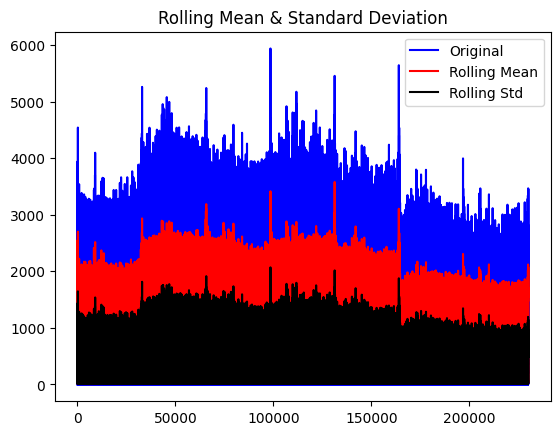

Results of Dickey-Fuller Test:
Test Statistic                    -32.341769
p-value                             0.000000
#Lags Used                         84.000000
Number of Observations Used    230045.000000
Critical Value (1%)                -3.430378
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64


(np.float64(-32.34176903360489),
 0.0,
 84,
 230045,
 {'1%': np.float64(-3.430378426494685),
  '5%': np.float64(-2.8615525641435626),
  '10%': np.float64(-2.56677668744033)},
 np.float64(3200717.280282874))

In [77]:
# test for stationarity using ADF test

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=7).mean()
    rolstd = timeseries.rolling(window=7).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return dftest

test_stationarity(train['num_sold'])

Holographic Goose
(46026, 9)


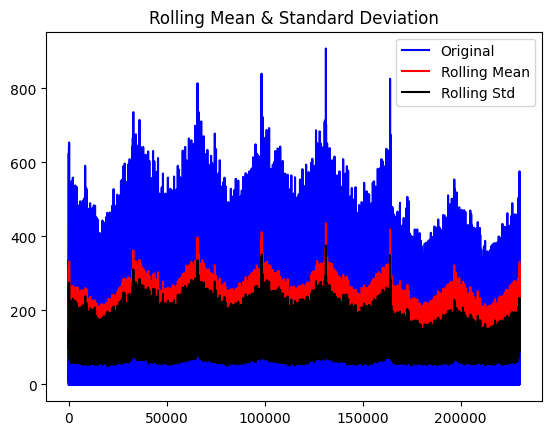

Results of Dickey-Fuller Test:
Test Statistic                -1.284548e+01
p-value                        5.492072e-24
#Lags Used                     5.400000e+01
Number of Observations Used    4.597100e+04
Critical Value (1%)           -3.430492e+00
Critical Value (5%)           -2.861603e+00
Critical Value (10%)          -2.566803e+00
dtype: float64
Kaggle
(46026, 9)


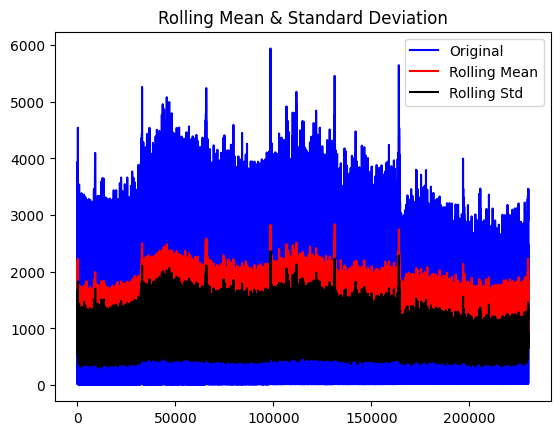

Results of Dickey-Fuller Test:
Test Statistic                -1.637281e+01
p-value                        2.799647e-29
#Lags Used                     5.600000e+01
Number of Observations Used    4.596900e+04
Critical Value (1%)           -3.430492e+00
Critical Value (5%)           -2.861603e+00
Critical Value (10%)          -2.566803e+00
dtype: float64
Kaggle Tiers
(46026, 9)


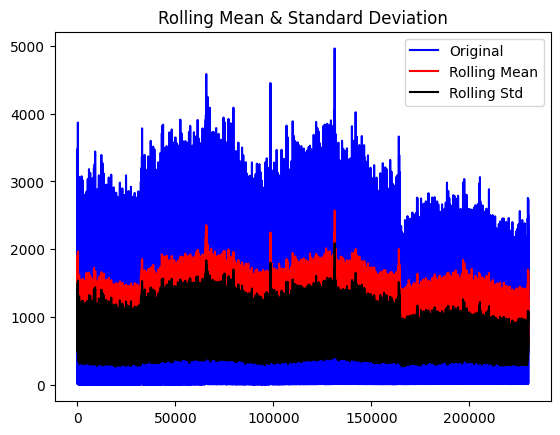

Results of Dickey-Fuller Test:
Test Statistic                -1.627491e+01
p-value                        3.458250e-29
#Lags Used                     5.600000e+01
Number of Observations Used    4.596900e+04
Critical Value (1%)           -3.430492e+00
Critical Value (5%)           -2.861603e+00
Critical Value (10%)          -2.566803e+00
dtype: float64
Kerneler
(46026, 9)


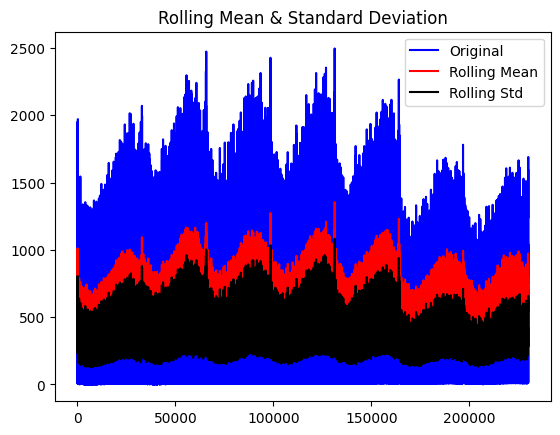

Results of Dickey-Fuller Test:
Test Statistic                -1.134085e+01
p-value                        1.055522e-20
#Lags Used                     5.600000e+01
Number of Observations Used    4.596900e+04
Critical Value (1%)           -3.430492e+00
Critical Value (5%)           -2.861603e+00
Critical Value (10%)          -2.566803e+00
dtype: float64
Kerneler Dark Mode
(46026, 9)


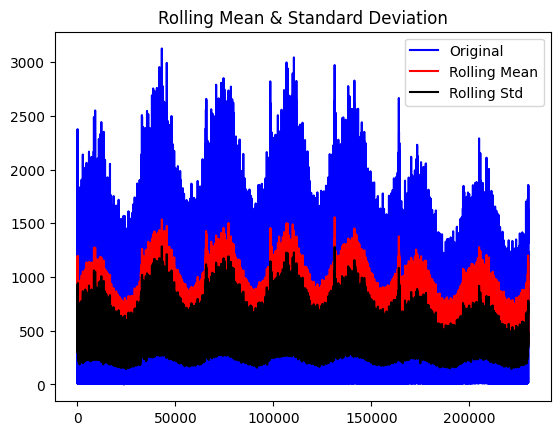

Results of Dickey-Fuller Test:
Test Statistic                -9.564357e+00
p-value                        2.379010e-16
#Lags Used                     5.600000e+01
Number of Observations Used    4.596900e+04
Critical Value (1%)           -3.430492e+00
Critical Value (5%)           -2.861603e+00
Critical Value (10%)          -2.566803e+00
dtype: float64


In [82]:
for product in train['product'].unique():
    print(product)
    train_series = train.loc[train['product'] == product]
    print(train_series.shape)
    test_stationarity(train_series['num_sold'])

### ADF Tests Have passed indicating no strong stationarity

- In summary, we will add the month, year and season columns for potential dummy variables to account for minor seasonality. 
- We will also address the strong outliers with Kenya and Canada selling less stickers

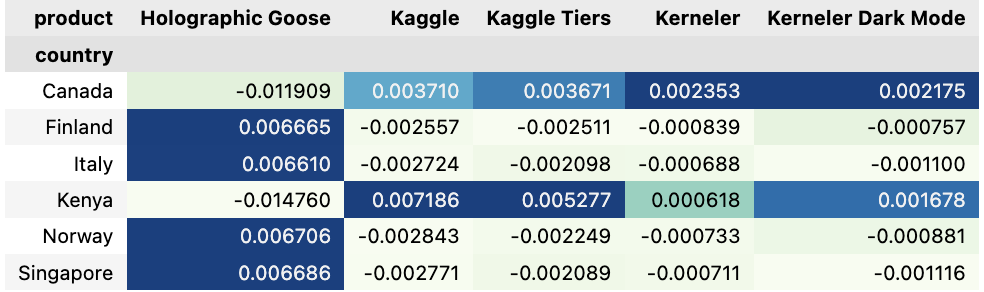

In [ ]:
train.loc[(train['num_sold'] == 0)].groupby(['country', 'store', 'product'])['num_sold'].count().astype(int).unstack().reset_index().fillna(0).style.background_gradient(axis=None, cmap="GnBu")

product,country,store,Holographic Goose
0,Canada,Discount Stickers,2557
1,Canada,Premium Sticker Mart,380
2,Canada,Stickers for Less,1308
3,Kenya,Discount Stickers,2557
4,Kenya,Premium Sticker Mart,646
5,Kenya,Stickers for Less,1358


In [155]:
train['year'] = train.year.astype(str)
display = train.loc[(train['num_sold'] == 0) & (train['product'] == 'Holographic Goose')].groupby(['country', 'store', 'product','year','season'])['num_sold'].count().astype(int).unstack().reset_index().fillna(0)
display = display.sort_values(by=['country', 'store', 'product', 'year'], ascending=False)


display.style.background_gradient(axis=None, cmap="GnBu")

season,country,store,product,year,Autumn,Spring,Summer,Winter
40,Kenya,Stickers for Less,Holographic Goose,2016,1.000000,4.000000,23.000000,0.000000
39,Kenya,Stickers for Less,Holographic Goose,2015,4.000000,22.000000,51.000000,1.000000
38,Kenya,Stickers for Less,Holographic Goose,2014,15.000000,33.000000,64.000000,1.000000
37,Kenya,Stickers for Less,Holographic Goose,2013,41.000000,66.000000,80.000000,13.000000
36,Kenya,Stickers for Less,Holographic Goose,2012,68.000000,74.000000,89.000000,34.000000
35,Kenya,Stickers for Less,Holographic Goose,2011,87.000000,85.000000,92.000000,67.000000
34,Kenya,Stickers for Less,Holographic Goose,2010,86.000000,92.000000,92.000000,73.000000
33,Kenya,Premium Sticker Mart,Holographic Goose,2015,0.000000,0.000000,2.000000,0.000000
32,Kenya,Premium Sticker Mart,Holographic Goose,2014,0.000000,0.000000,10.000000,0.000000
31,Kenya,Premium Sticker Mart,Holographic Goose,2013,2.000000,11.000000,35.000000,0.000000


### less demand for the holographic goose sticker in the summer 
### discount stickers does sell any Holographic Goose stickers 